In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import transforms
import torch.utils.data
import torch.nn.functional as F
import numpy as np
import pandas as pd 
import random
from PIL import Image
import os
import matplotlib.pyplot as plt

Загружаем датасет

In [58]:
path = "C:\\Users\\user\\Desktop\\Python2\\Lab2\\set\\dataset_another.csv"
dframe = pd.read_csv(
    path, delimiter=",", names=["Absolute path", "Relative path", "Class"]
)
img_list = dframe["Absolute path"].tolist()
random.shuffle(img_list)
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['cat', 'dog', 'dog', 'cat', 'cat']


Разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10)

In [59]:
training_list = img_list[0 : int(len(img_list) * 0.8)]
testing_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
validation_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))] 
print(len(training_list ), len(testing_list), len(validation_list))

1676 210 210


Демонстрация картинок

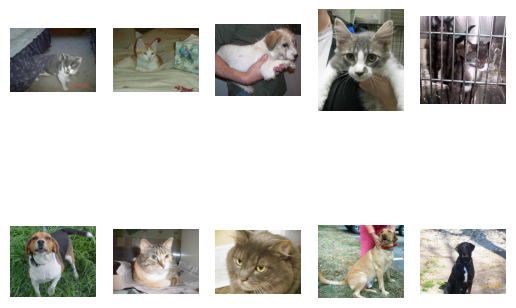

In [61]:
random_idx = np.random.randint(1,len(img_list),size=10)
fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i) 
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off') 
plt.show()

Для загрузки наборов изображений

In [62]:
class dataset(torch.utils.data.Dataset):  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    # dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    # load an one of images
    def __getitem__(self, idx):
        img_label = []
        for i in range(len(self.file_list)):
            img_label.append(os.path.basename(
                os.path.dirname(self.file_list[i])))
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB') 
        img_transformed = self.transform(img)
        label = img_label[idx]
        if label == "cat":
            label = 0
        elif label == "dog":
            label = 1
        return img_transformed, label

Формируем набор данных для обучения

In [63]:
transform = transforms.Compose(
    [
        transforms.Resize([224, 224]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
train_data = dataset(training_list, transform=transform)
test_data = dataset(testing_list, transform=transform)
val_data = dataset(validation_list, transform=transform)
print(len(train_data), len(test_data), len(val_data))
train_data[0][0].shape

1676 210 210


torch.Size([3, 224, 224])

Класс построения сверточной модели:
    1. 3 слоя свертки и 2 полностью связанных слоя
    2. пакетная нормализация для ограничения переобучения

In [64]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(3 * 3 * 64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [65]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=0.1) 
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(1 / m.in_features))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Conv1d):
        nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(4 / m.in_channels))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
model = Cnn()
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Демонстрация графиков

In [67]:
def show_results(epochs, acc, loss, val_acc, val_loss) -> None: 
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(range(epochs), acc, color="green", label="Train")
    ax[1].plot(range(epochs), loss, color="green", label="Train")
    ax[0].plot(range(epochs), val_acc, color="crimson", label="Validation")
    ax[1].plot(range(epochs), val_loss, color="crimson", label="Validation")
    ax[0].set_title('Accuracy')
    ax[1].set_title('Loss')
    ax[0].legend()
    ax[1].legend()
    fig.suptitle('The result of the training')
    plt.show()

Обучающие циклы

In [68]:
def train_loop(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    show_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Эксперименты по обучению с различными значениями параметров learning rate (скорость обучения) и batch size (размер мини-пакета)

Epoch : 1, train accuracy : 0.5835930705070496, train loss : 0.6737621426582336
Epoch : 1, val_accuracy : 0.5708805322647095, val_loss : 0.6736596822738647
Epoch : 2, train accuracy : 0.6221644878387451, train loss : 0.6509212255477905
Epoch : 2, val_accuracy : 0.5812578797340393, val_loss : 0.7011904716491699
Epoch : 3, train accuracy : 0.6252813935279846, train loss : 0.6527230143547058
Epoch : 3, val_accuracy : 0.6308804750442505, val_loss : 0.6605223417282104
Epoch : 4, train accuracy : 0.627186119556427, train loss : 0.6365710496902466
Epoch : 4, val_accuracy : 0.5935220122337341, val_loss : 0.6706409454345703
Epoch : 5, train accuracy : 0.6417748928070068, train loss : 0.6267820596694946
Epoch : 5, val_accuracy : 0.6083018779754639, val_loss : 0.6604268550872803
Epoch : 6, train accuracy : 0.6789610981941223, train loss : 0.5998702645301819
Epoch : 6, val_accuracy : 0.5716352462768555, val_loss : 0.6739887595176697
Epoch : 7, train accuracy : 0.6805627942085266, train loss : 0.60

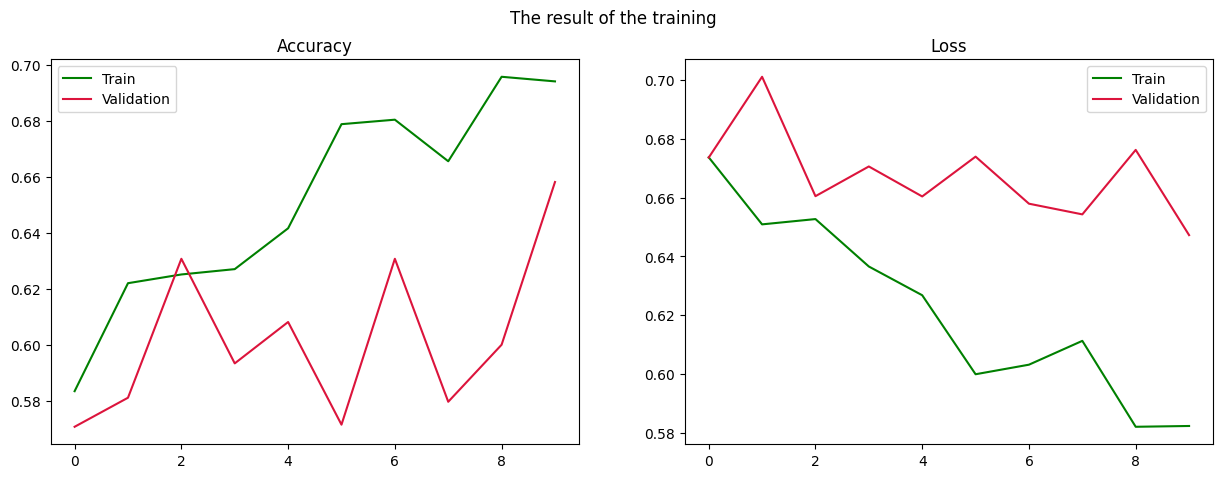

In [43]:
train_loop(10, 100, 0.0015)

Epoch : 1, train accuracy : 0.6107812523841858, train loss : 0.6603829860687256
Epoch : 1, val_accuracy : 0.6187499761581421, val_loss : 0.6442888379096985
Epoch : 2, train accuracy : 0.6506249308586121, train loss : 0.6236297488212585
Epoch : 2, val_accuracy : 0.6562499403953552, val_loss : 0.6026968955993652
Epoch : 3, train accuracy : 0.684374988079071, train loss : 0.5899244546890259
Epoch : 3, val_accuracy : 0.6837500333786011, val_loss : 0.5936112403869629
Epoch : 4, train accuracy : 0.6953125, train loss : 0.5724329948425293
Epoch : 4, val_accuracy : 0.6775000095367432, val_loss : 0.6005927920341492
Epoch : 5, train accuracy : 0.7079687118530273, train loss : 0.555796205997467
Epoch : 5, val_accuracy : 0.6737500429153442, val_loss : 0.6163021326065063
Epoch : 6, train accuracy : 0.7073437571525574, train loss : 0.5588005781173706
Epoch : 6, val_accuracy : 0.7324999570846558, val_loss : 0.5442180037498474
Epoch : 7, train accuracy : 0.7276561260223389, train loss : 0.535421609878

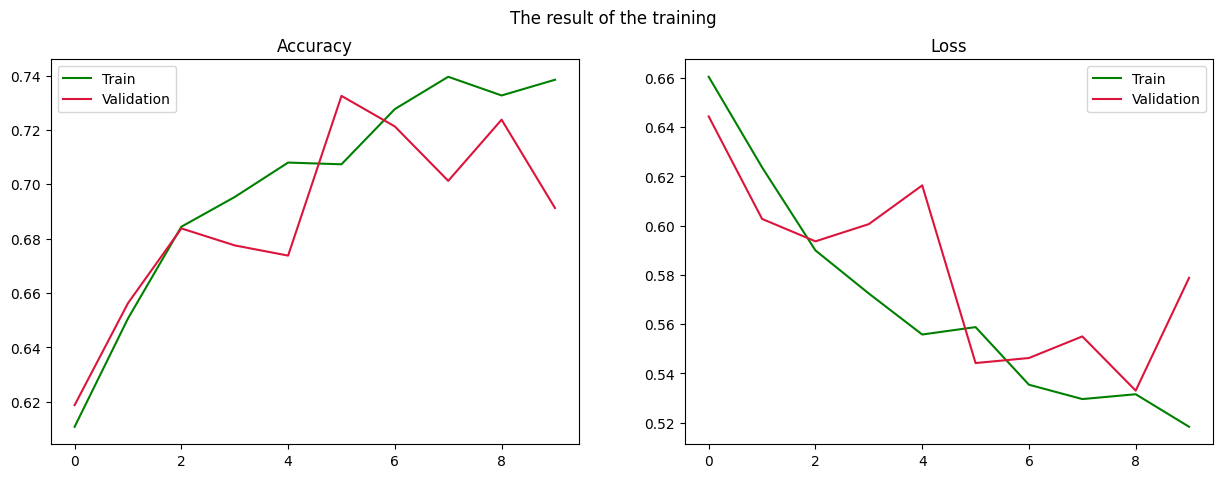

In [13]:
train_loop(10, 200, 0.0015)

Epoch : 1, train accuracy : 0.5352039337158203, train loss : 0.6919795870780945
Epoch : 1, val_accuracy : 0.6407246589660645, val_loss : 0.662251889705658
Epoch : 2, train accuracy : 0.6029043793678284, train loss : 0.6598305106163025
Epoch : 2, val_accuracy : 0.6697101593017578, val_loss : 0.6430521011352539
Epoch : 3, train accuracy : 0.6214205026626587, train loss : 0.6487488150596619
Epoch : 3, val_accuracy : 0.6842029094696045, val_loss : 0.6269016861915588
Epoch : 4, train accuracy : 0.6385302543640137, train loss : 0.6320514678955078
Epoch : 4, val_accuracy : 0.7163768410682678, val_loss : 0.6038926243782043
Epoch : 5, train accuracy : 0.6627144813537598, train loss : 0.6147366166114807
Epoch : 5, val_accuracy : 0.7475362420082092, val_loss : 0.5636460185050964
Epoch : 6, train accuracy : 0.6722362637519836, train loss : 0.6028484106063843
Epoch : 6, val_accuracy : 0.7152174115180969, val_loss : 0.5599231123924255
Epoch : 7, train accuracy : 0.6827144622802734, train loss : 0.58

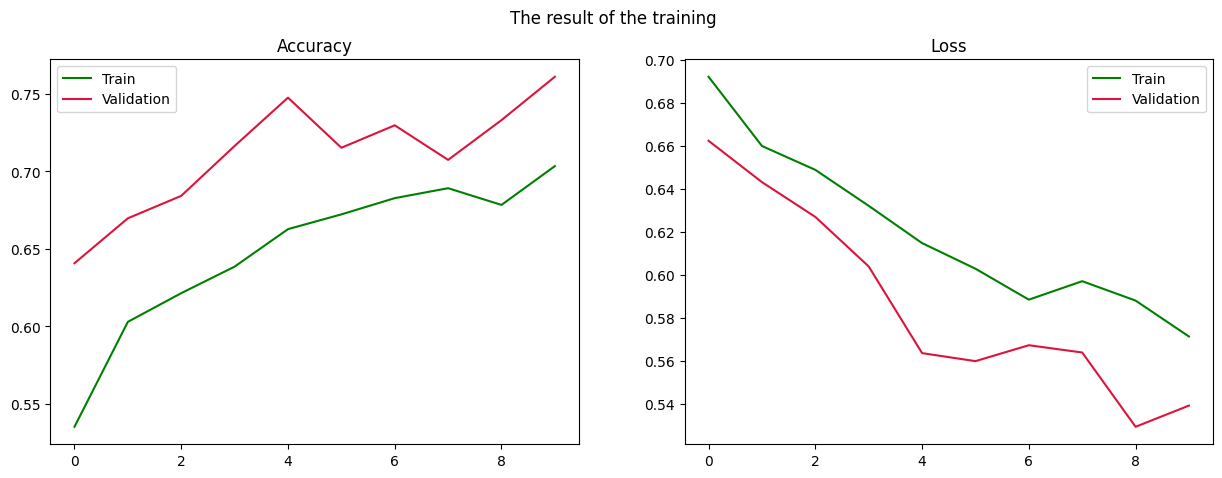

In [14]:
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.5689043998718262, train loss : 0.731332540512085
Epoch : 1, val_accuracy : 0.5526087284088135, val_loss : 0.663892388343811
Epoch : 2, train accuracy : 0.6272687911987305, train loss : 0.6477636098861694
Epoch : 2, val_accuracy : 0.5651086568832397, val_loss : 0.634188175201416
Epoch : 3, train accuracy : 0.6522004008293152, train loss : 0.6272575855255127
Epoch : 3, val_accuracy : 0.6635869741439819, val_loss : 0.6276534795761108
Epoch : 4, train accuracy : 0.6953041553497314, train loss : 0.6204332113265991
Epoch : 4, val_accuracy : 0.6535869836807251, val_loss : 0.605958104133606
Epoch : 5, train accuracy : 0.6730509400367737, train loss : 0.6145193576812744
Epoch : 5, val_accuracy : 0.6251087188720703, val_loss : 0.6314027905464172
Epoch : 6, train accuracy : 0.6802048087120056, train loss : 0.6092938780784607
Epoch : 6, val_accuracy : 0.6593477725982666, val_loss : 0.5933751463890076
Epoch : 7, train accuracy : 0.6985381245613098, train loss : 0.57813

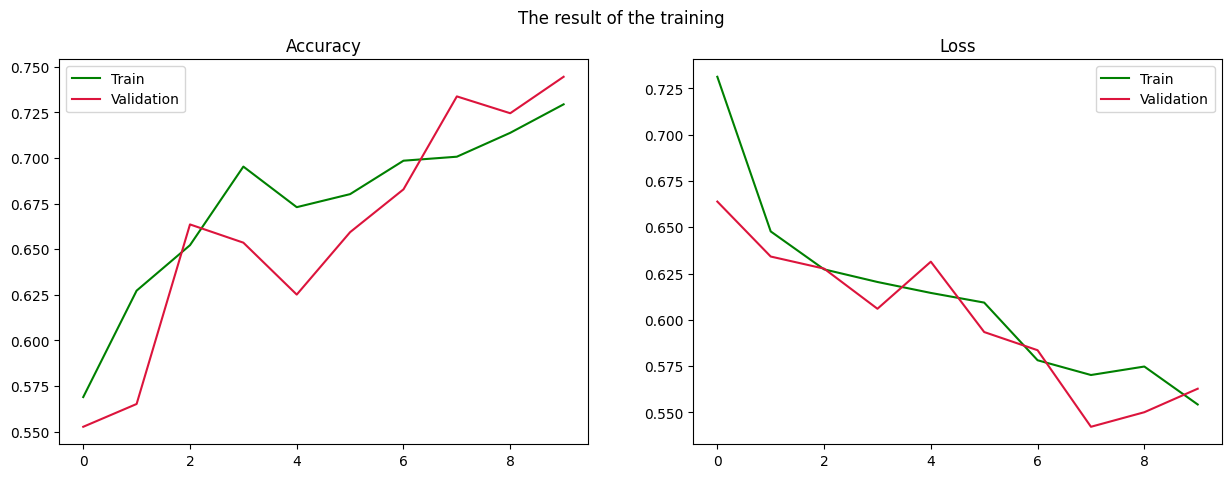

In [20]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.6626105308532715, train loss : 0.6315861940383911
Epoch : 1, val_accuracy : 0.726457417011261, val_loss : 0.5565813779830933
Epoch : 2, train accuracy : 0.7105316519737244, train loss : 0.5562238693237305
Epoch : 2, val_accuracy : 0.6547085046768188, val_loss : 0.618070125579834
Epoch : 3, train accuracy : 0.6960275173187256, train loss : 0.566453218460083
Epoch : 3, val_accuracy : 0.7040358781814575, val_loss : 0.5901613831520081
Epoch : 4, train accuracy : 0.7234886288642883, train loss : 0.5438895225524902
Epoch : 4, val_accuracy : 0.7399103045463562, val_loss : 0.5375804305076599
Epoch : 5, train accuracy : 0.7276284694671631, train loss : 0.5393809080123901
Epoch : 5, val_accuracy : 0.7533632516860962, val_loss : 0.521620512008667
Epoch : 6, train accuracy : 0.7371982932090759, train loss : 0.52646404504776
Epoch : 6, val_accuracy : 0.7354260087013245, val_loss : 0.5461990237236023
Epoch : 7, train accuracy : 0.737335741519928, train loss : 0.52273780

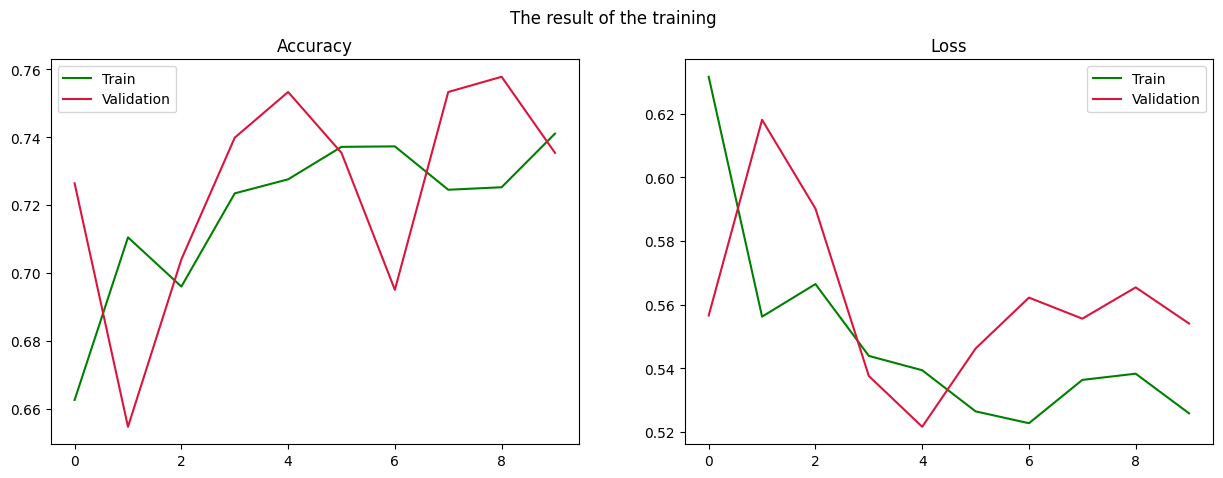

In [21]:
train_loop(10, 300, 0.001)

Epoch : 1, train accuracy : 0.5014978647232056, train loss : 0.6938653588294983
Epoch : 1, val_accuracy : 0.4815942049026489, val_loss : 0.6940763592720032
Epoch : 2, train accuracy : 0.5006117820739746, train loss : 0.6932698488235474
Epoch : 2, val_accuracy : 0.4815942049026489, val_loss : 0.6936160326004028
Epoch : 3, train accuracy : 0.483094185590744, train loss : 0.6932747960090637
Epoch : 3, val_accuracy : 0.5184057950973511, val_loss : 0.6930731534957886
Epoch : 4, train accuracy : 0.4920182526111603, train loss : 0.6932552456855774
Epoch : 4, val_accuracy : 0.4815942049026489, val_loss : 0.6933131814002991
Epoch : 5, train accuracy : 0.4889451861381531, train loss : 0.6932666301727295
Epoch : 5, val_accuracy : 0.5184057950973511, val_loss : 0.6930880546569824
Epoch : 6, train accuracy : 0.4893530309200287, train loss : 0.6932288408279419
Epoch : 6, val_accuracy : 0.4815942049026489, val_loss : 0.6932797431945801
Epoch : 7, train accuracy : 0.48661044239997864, train loss : 0.6

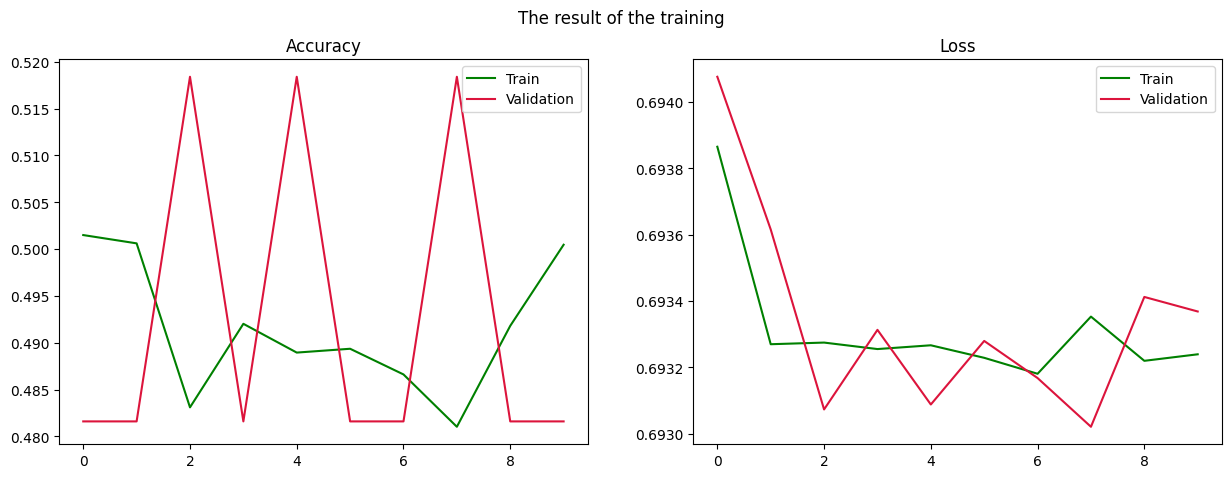

In [23]:
train_loop(10, 100, 0.004)

Epoch : 1, train accuracy : 0.5011265873908997, train loss : 0.6933316588401794
Epoch : 1, val_accuracy : 0.4698913097381592, val_loss : 0.6936314702033997
Epoch : 2, train accuracy : 0.5007355809211731, train loss : 0.693187952041626
Epoch : 2, val_accuracy : 0.4698913097381592, val_loss : 0.6932572722434998
Epoch : 3, train accuracy : 0.49240225553512573, train loss : 0.6932007074356079
Epoch : 3, val_accuracy : 0.5301086902618408, val_loss : 0.69313645362854
Epoch : 4, train accuracy : 0.4943296015262604, train loss : 0.6932099461555481
Epoch : 4, val_accuracy : 0.4698913097381592, val_loss : 0.6933320760726929
Epoch : 5, train accuracy : 0.5011917948722839, train loss : 0.6931601166725159
Epoch : 5, val_accuracy : 0.4698913097381592, val_loss : 0.6932079792022705
Epoch : 6, train accuracy : 0.4811607599258423, train loss : 0.6932395100593567
Epoch : 6, val_accuracy : 0.5301086902618408, val_loss : 0.6930262446403503
Epoch : 7, train accuracy : 0.4853103458881378, train loss : 0.693

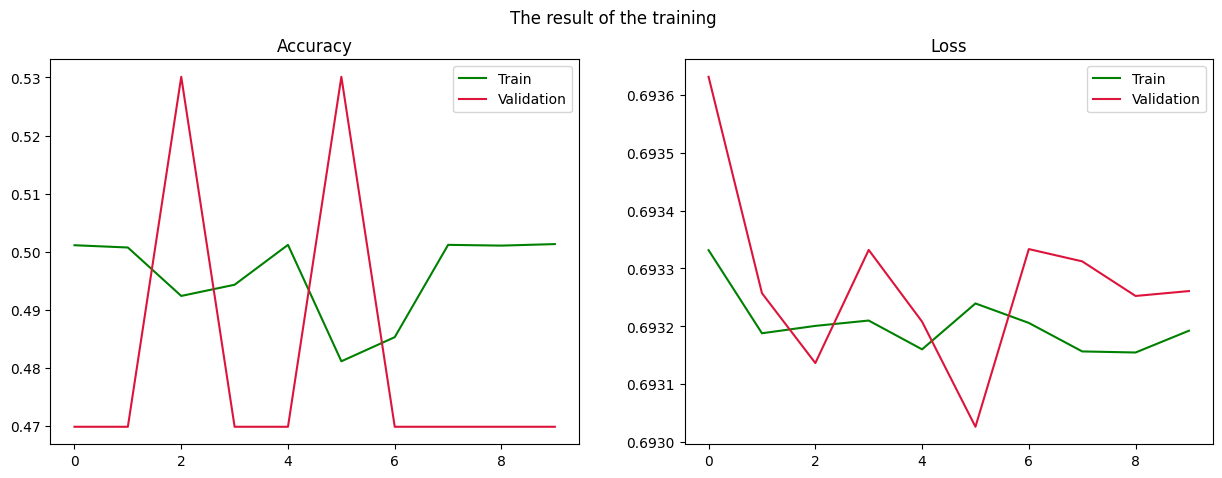

In [24]:
train_loop(10, 200, 0.004)

Epoch : 1, train accuracy : 0.49354836344718933, train loss : 0.6931771636009216
Epoch : 1, val_accuracy : 0.5022421479225159, val_loss : 0.6931437253952026
Epoch : 2, train accuracy : 0.49893665313720703, train loss : 0.6931827068328857
Epoch : 2, val_accuracy : 0.5022421479225159, val_loss : 0.6931406259536743
Epoch : 3, train accuracy : 0.495089590549469, train loss : 0.6931709051132202
Epoch : 3, val_accuracy : 0.49775785207748413, val_loss : 0.6931572556495667
Epoch : 4, train accuracy : 0.5001015663146973, train loss : 0.6932005286216736
Epoch : 4, val_accuracy : 0.49775785207748413, val_loss : 0.6931653022766113
Epoch : 5, train accuracy : 0.501063346862793, train loss : 0.6931540966033936
Epoch : 5, val_accuracy : 0.49775785207748413, val_loss : 0.6931623220443726
Epoch : 6, train accuracy : 0.5008542537689209, train loss : 0.6931694746017456
Epoch : 6, val_accuracy : 0.49775785207748413, val_loss : 0.6931622624397278
Epoch : 7, train accuracy : 0.5007705688476562, train loss :

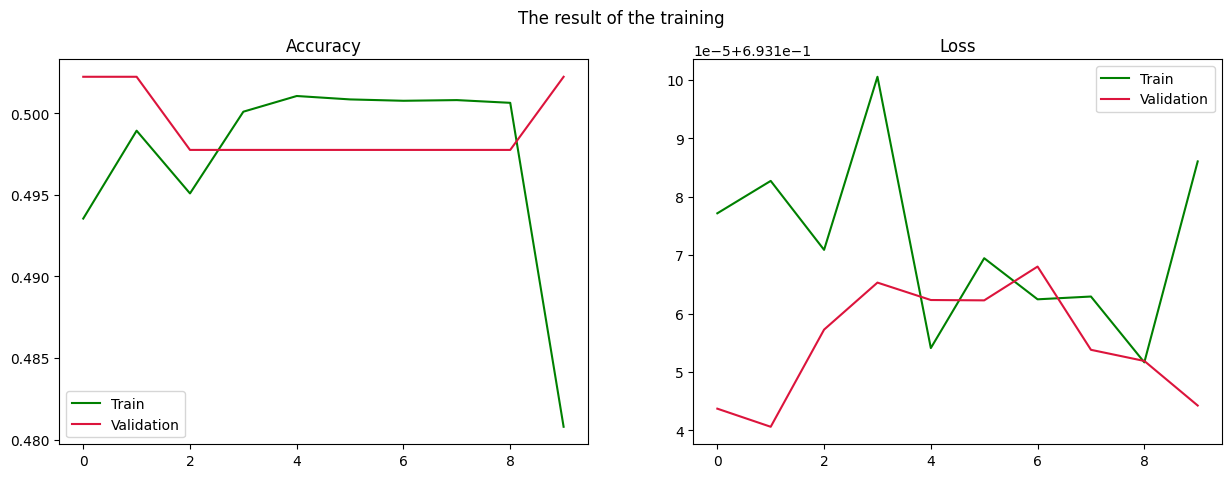

In [25]:
train_loop(10, 300, 0.004)

Epoch : 1, train accuracy : 0.48921945691108704, train loss : 0.6932041645050049
Epoch : 1, val_accuracy : 0.5252747535705566, val_loss : 0.6930549740791321
Epoch : 2, train accuracy : 0.48207658529281616, train loss : 0.6932422518730164
Epoch : 2, val_accuracy : 0.47472527623176575, val_loss : 0.6932417154312134
Epoch : 3, train accuracy : 0.4705381691455841, train loss : 0.6931953430175781
Epoch : 3, val_accuracy : 0.5252747535705566, val_loss : 0.693131685256958
Epoch : 4, train accuracy : 0.4850512146949768, train loss : 0.6931605339050293
Epoch : 4, val_accuracy : 0.47472527623176575, val_loss : 0.6931869983673096
Epoch : 5, train accuracy : 0.47218650579452515, train loss : 0.6932247281074524
Epoch : 5, val_accuracy : 0.47472527623176575, val_loss : 0.6933081746101379
Epoch : 6, train accuracy : 0.4988822340965271, train loss : 0.6931806206703186
Epoch : 6, val_accuracy : 0.47472527623176575, val_loss : 0.6932637691497803
Epoch : 7, train accuracy : 0.4967223107814789, train loss

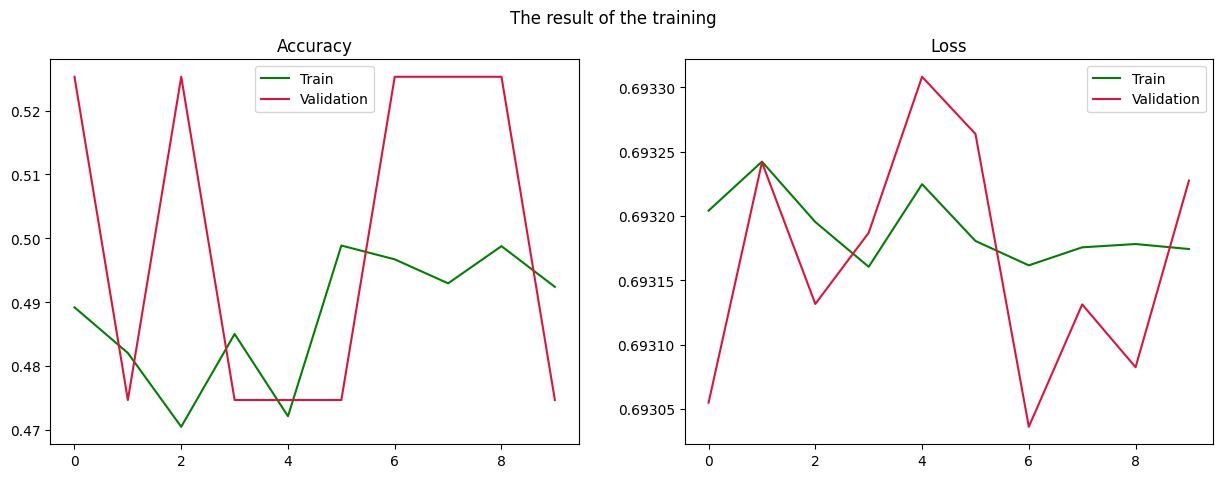

In [26]:
train_loop(10, 100, 0.008)

Epoch : 1, train accuracy : 0.5107602477073669, train loss : 0.7401960492134094
Epoch : 1, val_accuracy : 0.45749998092651367, val_loss : 0.6894429922103882
Epoch : 2, train accuracy : 0.5027778148651123, train loss : 0.6892421245574951
Epoch : 2, val_accuracy : 0.5325000286102295, val_loss : 0.6850432753562927
Epoch : 3, train accuracy : 0.5709064602851868, train loss : 0.6834537386894226
Epoch : 3, val_accuracy : 0.6625000238418579, val_loss : 0.6663681268692017
Epoch : 4, train accuracy : 0.6005262136459351, train loss : 0.676161527633667
Epoch : 4, val_accuracy : 0.6349999904632568, val_loss : 0.6583304405212402
Epoch : 5, train accuracy : 0.6024853587150574, train loss : 0.6708127856254578
Epoch : 5, val_accuracy : 0.5575000047683716, val_loss : 0.6766132116317749
Epoch : 6, train accuracy : 0.6209941506385803, train loss : 0.6601704955101013
Epoch : 6, val_accuracy : 0.7250000238418579, val_loss : 0.6198107004165649
Epoch : 7, train accuracy : 0.6392689943313599, train loss : 0.6

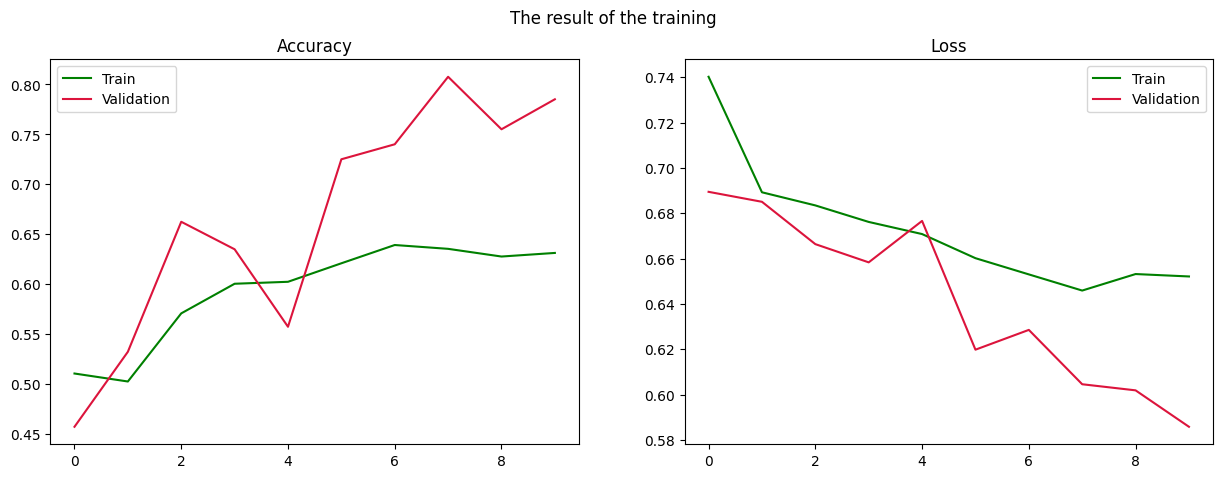

In [69]:
train_loop(10, 200, 0.008)

Epoch : 1, train accuracy : 0.5161001086235046, train loss : 0.703270673751831
Epoch : 1, val_accuracy : 0.5893719792366028, val_loss : 0.6799495816230774
Epoch : 2, train accuracy : 0.5949227213859558, train loss : 0.6807547807693481
Epoch : 2, val_accuracy : 0.5507246255874634, val_loss : 0.6840673089027405
Epoch : 3, train accuracy : 0.6181751489639282, train loss : 0.6685531139373779
Epoch : 3, val_accuracy : 0.6038647294044495, val_loss : 0.6841698288917542
Epoch : 4, train accuracy : 0.6065305471420288, train loss : 0.6680585145950317
Epoch : 4, val_accuracy : 0.6183574795722961, val_loss : 0.6727023720741272
Epoch : 5, train accuracy : 0.6220861673355103, train loss : 0.655707836151123
Epoch : 5, val_accuracy : 0.6328502297401428, val_loss : 0.6798070073127747
Epoch : 6, train accuracy : 0.6198564767837524, train loss : 0.6515982151031494
Epoch : 6, val_accuracy : 0.5990338325500488, val_loss : 0.6791129112243652
Epoch : 7, train accuracy : 0.6425827741622925, train loss : 0.643

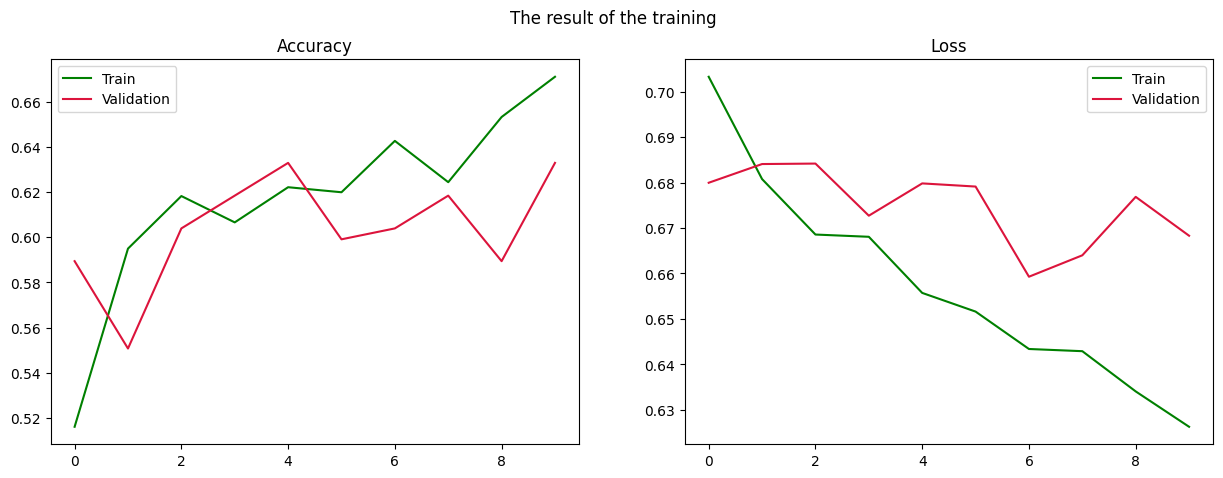

In [53]:
train_loop(10, 300, 0.008)

В самом начале точность валидационной выборки обучения была наибольшей. В дальнейшем, точность снижалась. Вероятрно модель уже начала переобучаться. В среднем точность валидационной выборки была ниже, чeм тестовой. С увеличением размера мини-пакета разница между точностью обучающей и валидационной выборкой становилась меньше. В те моменты, когда точность валидационной выборки была больше, чем обучающей, модель, вероятно, распознавала больше отличительных признаков какого-либо класса

Создание csv-файл с полученными результатами

In [100]:
cat_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=100, shuffle=False)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        cat_probs += list(zip(list(fileid), preds_list))
cat_probs.sort(key = lambda x : int(x[0]))
id = list(range(len(cat_probs)))
label = list(map(lambda x: x[1], cat_probs))
submission = pd.DataFrame({'id':id, 'label':label})
submission.to_csv('final.csv', index=False)
submission

,id,label
0,0,0.733755
1,1,0.511747
2,2,0.526007
3,3,0.437320
4,4,0.675212
...,...,...
201,201,0.437320
202,202,0.655482
203,203,0.437320
204,204,0.646753


Сохранение модели

In [57]:
torch.save(model.state_dict(), os.path.join("C:\\Users\\user\\Desktop\\Python2\\Lab5", "lab5_final.pt")) 
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("C:\\Users\\user\\Desktop\\Python2\\Lab5", "lab5_final.pt")))

<All keys matched successfully>

Проверка модели на работоспособность

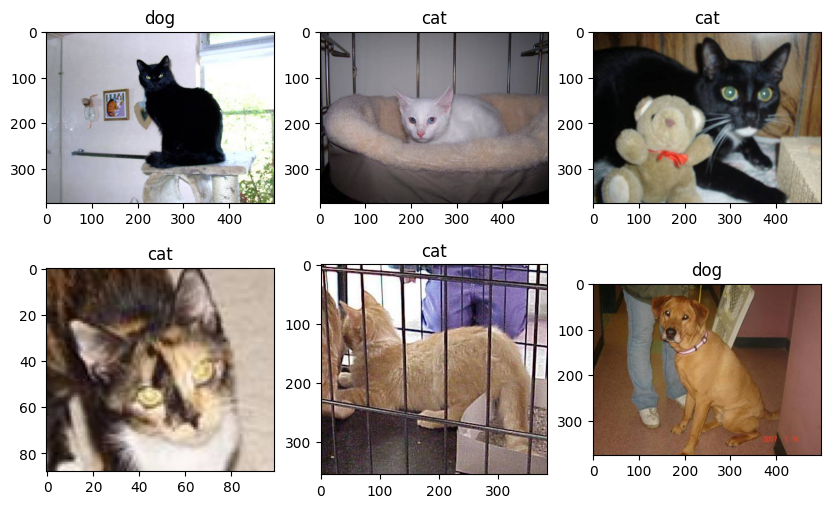

In [75]:
id_list = []
class_ = {0: "cat", 1: "dog"} 
fig, axes = plt.subplots(2, 3, figsize=(10, 6), facecolor='w') 
for ax in axes.ravel(): 
    i = random.randint(0, len(submission['id'].values) - 1)
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0 
    img_path = training_list[i]
    img = Image.open(img_path).convert('RGB') 
    
    ax.set_title(class_[label])
    ax.imshow(img)